# Important information about this EDA, (Exploratory Data Analysis)
Exploring the files in the 'data/processed/' directory<br>

**Please note:** The analysis will be divided into four distinct sections, each addressing different files, as outlined below::
- App usage in the phone, (Files: 'app_usage_count_motorola.csv' and 'app_usage_time_motorola.csv')
- Device unlocks analysis, (Files: 'device_unlocks_motorola.csv')
- Web usage count, (Files: 'web_usage_count_chrome.csv', 'web_usage_count_edge.csv', 'web_usage_count_motorola.csv')
- Web usage time, (Files: 'web_usage_time_chrome.csv', 'web_usage_time_edge.csv', 'web_usage_time_motorola.csv')

*App usage time* and *Web usage time* files have every column except the date to be in minutes.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_theme(style="whitegrid")

Connection to the sql server database

In [124]:
def read_from_sql_database(server, database, username, password, driver, queries):
    # Creating the SQLAlchemy connection
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"
    engine = create_engine(connection_string)
    dataframes = {}
    for query in queries:
        dataframes[query.split()[-1]] = pd.read_sql(query, engine, parse_dates=['date'])
        
    return dataframes

# Connection parameters
server = 'DESKTOP-8PK64UI'
database = 'statistics_of_use_db'
username = 'main_estiven'
driver = 'ODBC+Driver+17+for+SQL+Server'

password_file_path = "database_pass.txt"
with open(password_file_path, "r") as file:
    password = file.read().strip()

Reading the files for App usage in the phone

In [125]:
sql_queries = ["SELECT * FROM app_usage_count_motorola", "SELECT * FROM app_usage_time_motorola", 
               "SELECT * FROM web_usage_time_edge", "SELECT * FROM device_unlocks_motorola"]
result_df = read_from_sql_database(server, database, username, password, driver, sql_queries)

app_count_motorola = result_df['app_usage_count_motorola']
app_time_motorola = result_df['app_usage_time_motorola']
web_time_edge = result_df['web_usage_time_edge']
device_unlocks = result_df['device_unlocks_motorola']

count_columns = list(app_count_motorola.columns)
time_columns = list(app_time_motorola.columns)

# Exploratory Data Analysis

## App usage in the phone

Overview of the datasets

In [126]:
print(f'App count motorola:\n{app_count_motorola.head(1)}\n')
print(f'App count motorola:\n{app_time_motorola.head(1)}\n')
print(f'Web time edge:\n{web_time_edge.head(1)}\n')
print(f'Device unlocks:\n{device_unlocks.head(1)}\n')

App count motorola:
        date  amazon_shopping  android_system  calculator  calendar  camera  chrome  classroom  clock  discord  drive  files  gmail  google  google_news  google_opinion_rewards  google_play_services  google_play_store  instagram  linkedin  maps  medium  mi_tigo  microsoft_365_(office)  moto_app_launcher  nequi_colombia  notion  package_installer  photomath  photos  settings  siata  simcity  spotify  stellarium  symbolab  system_ui  tasks  teams  telegram  tiktok  truecaller  twitter  tyba  upwork_talent  whatsapp  youtube  youtube_music  zoom  total_usage  apple_music  didi  freelancer  money_manager  paypal  sleepy  call_of_duty  chatgpt  cívica  clash_of_clans  hbo_max  rappi
0 2022-10-19              0.0             1.0         5.0       3.0     0.0    24.0        5.0    8.0      0.0   11.0    2.0    4.0     0.0          4.0                     2.0                   1.0                0.0       33.0       0.0   0.0     0.0      0.0                     0.0        

In [127]:
print(f'Shape of the motorola time usage dataframe, (ORIGINAL): {app_time_motorola.shape}\n\
Shape of the motorola count usage dataframe, (ORIGINAL): {app_count_motorola.shape}\n\
Shape of the edge time usage dataframe, (ORIGINAL): {web_time_edge.shape}\n\
Shape of the motorola unlocks dataframe, (ORIGINAL): {device_unlocks.shape}\n')

Shape of the motorola time usage dataframe, (ORIGINAL): (552, 52)
Shape of the motorola count usage dataframe, (ORIGINAL): (552, 62)
Shape of the edge time usage dataframe, (ORIGINAL): (330, 39)
Shape of the motorola unlocks dataframe, (ORIGINAL): (552, 2)



## Data transformation and cleaning

In [128]:
def percentage_of_zeros(dataframe: pd.DataFrame, dataframe_column: str) -> float:
    """
    Calculate the percentage of zero values in a specific column of a pandas DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    dataframe_column (str): The column name for which the percentage of zero values should be calculated.

    Returns:
    float: The percentage of zero values in the specified column, rounded to two decimal places.

    Example:
    >>> import pandas as pd
    >>> data = {'column_A': [0, 0, 3, 0, 5, 0, 0]}
    >>> df = pd.DataFrame(data)
    >>> percentage = percentage_of_zeros(df, 'column_A')
    >>> print(percentage)
    71.43
    """
    percentage_zeros = (dataframe[dataframe_column] == 0).astype(int).sum(axis=0) / dataframe.shape[0]
    return round(percentage_zeros * 100, 2)

Filtering the data so there are not too much zeros, if the column has more than 70% of zeros, it will be eliminated

In [129]:
def remove_zero_columns(df, threshold):
    """
    This function removes columns from a DataFrame that have a percentage of zeros greater than a specified threshold.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    threshold (float): The percentage threshold for zero values.

    Returns:
    pandas.DataFrame: The processed DataFrame with columns removed.
    """
    
    # Initialize a dictionary to store the percentage of zeros for each column
    percentages = {}

    for column in df:
        # Exclude the 'date' column from this process
        if column != 'date':
            # Calculate the percentage of zeros in the current column and store it in the dictionary
            percentages[column] = percentage_of_zeros(df, column)

    # Identify columns where the percentage of zeros exceeds the threshold
    columns_too_much_zeros = [key for key, value in percentages.items() if value > threshold]

    # Drop these columns from the DataFrame and return the result
    return df.drop(columns=columns_too_much_zeros)

# Applying the function to the dataframes
result_df['app_usage_count_motorola'] = remove_zero_columns(result_df['app_usage_count_motorola'], 70)
result_df['app_usage_time_motorola'] = remove_zero_columns(result_df['app_usage_time_motorola'], 70)
result_df['web_usage_time_edge'] = remove_zero_columns(result_df['web_usage_time_edge'], 70)
result_df['device_unlocks_motorola'] = remove_zero_columns(result_df['device_unlocks_motorola'], 70)

In [130]:
print(f'Shape of the motorola time usage dataframe: {app_time_motorola.shape}\n\
Shape of the motorola count usage dataframe: {app_count_motorola.shape}\n\
Shape of the edge time usage dataframe: {web_time_edge.shape}\n\
Shape of the motorola unlocks dataframe: {device_unlocks.shape}\n')

Shape of the motorola time usage dataframe: (552, 52)
Shape of the motorola count usage dataframe: (552, 62)
Shape of the edge time usage dataframe: (330, 39)
Shape of the motorola unlocks dataframe: (552, 2)



Top 5 most used applications in my phone and web browser Edge

In [131]:
most_used_apps_phone = app_time_motorola.loc[:, ~app_time_motorola.columns.isin(['date', 'total_usage'])].sum().sort_values(ascending=False)[:5] / 60
most_used_apps_phone = pd.DataFrame(most_used_apps_phone, index=None, columns=['total_usage (hours)']).reset_index().rename({'index': 'app_name'}, axis=1)
most_used_apps_phone

,app_name,total_usage (hours)
0,whatsapp,636.729125
1,instagram,504.435154
2,youtube,277.841353
3,chrome,115.225941
4,spotify,57.470743


In [132]:
most_used_web_edge = web_time_edge.loc[:, ~web_time_edge.columns.isin(['date', 'total_usage'])].sum().sort_values(ascending=False)[:5] / 60
most_used_web_edge = pd.DataFrame(most_used_web_edge, index=None, columns=['total_usage (hours)']).reset_index().rename({'index': 'app_name'}, axis=1)
most_used_web_edge

,app_name,total_usage (hours)
0,youtube.com,601.036833
1,instagram.com,59.452000
2,hbomax.com,52.381500
3,whatsapp.com,50.027833
4,chat.openai.com,45.418000


In [133]:
# Get the unique dates in each dataframe
device_dates = set(device_unlocks['date'].unique())
app_dates = set(app_time_motorola['date'].unique())

# Find dates that are in device_dates but not in app_dates
missing_in_app = device_dates.difference(app_dates)

# Find dates that are in app_dates but not in device_dates
missing_in_device = app_dates.difference(device_dates)

# Print missing dates
print("Dates missing in app_time_motorola:", missing_in_app)
print("Dates missing in device_unlocks:", missing_in_device)

# If you want to save these in a list, just convert the sets to lists
missing_in_app_list = list(missing_in_app)
missing_in_device_list = list(missing_in_device)

Dates missing in app_time_motorola: set()
Dates missing in device_unlocks: set()


Graphics from the data

Have in mind: 

| Minutes | Hours |
|---------|-------|
| 100     | 1.6   |
| 200     | 3.3   |
| 400     | 6.6   |

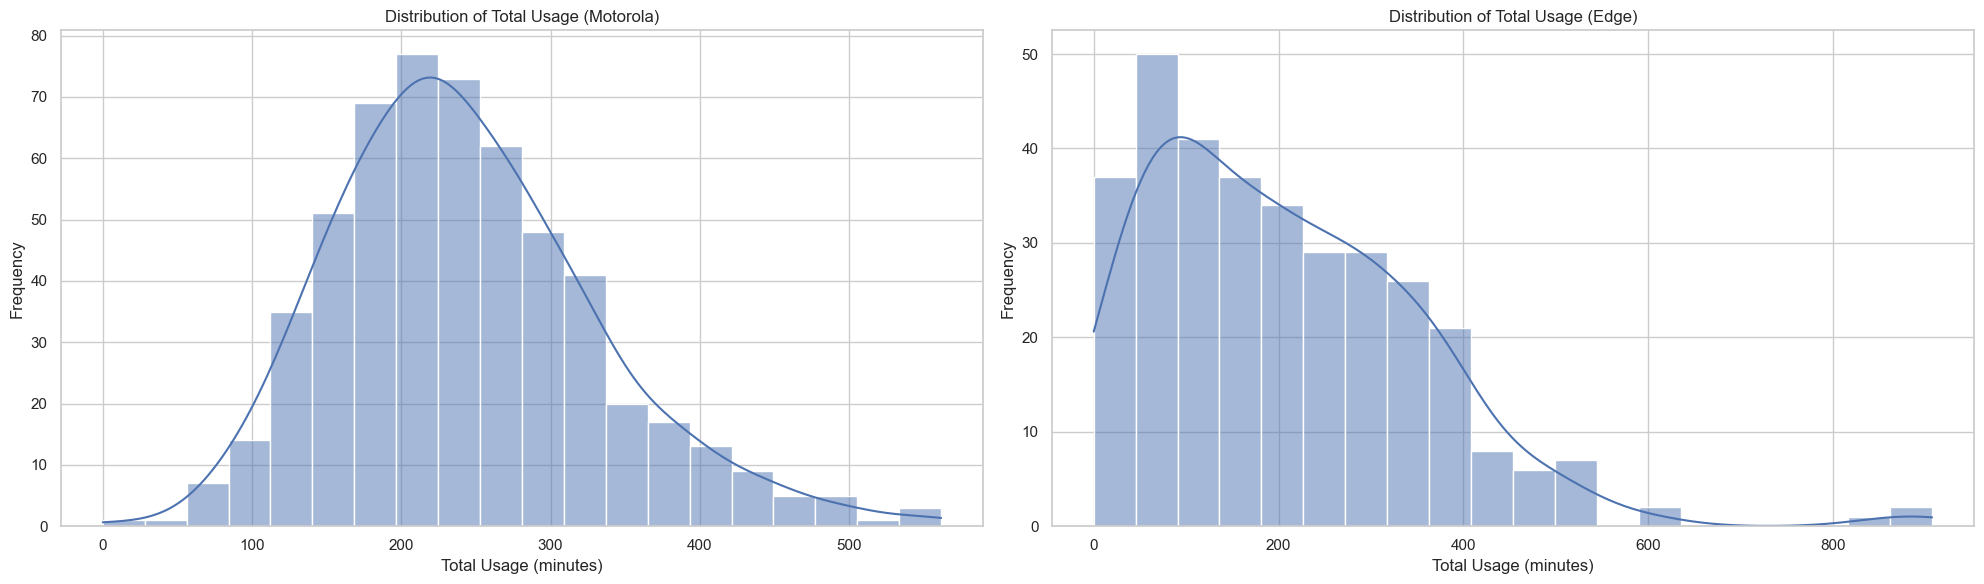

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Total usage time motorola histogram
sns.histplot(app_time_motorola['total_usage'], bins=20, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Total Usage (Motorola)')
axs[0].set_xlabel('Total Usage (minutes)')
axs[0].set_ylabel('Frequency')

# Total usage time edge histogram
sns.histplot(web_time_edge['total_usage'], bins=20, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Total Usage (Edge)')
axs[1].set_xlabel('Total Usage (minutes)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Creating a variable to store all the column names that are the applications in the dataframes

In [135]:
app_columns = app_time_motorola.columns[1:-1]
web_columns = web_time_edge.columns[1:-1]

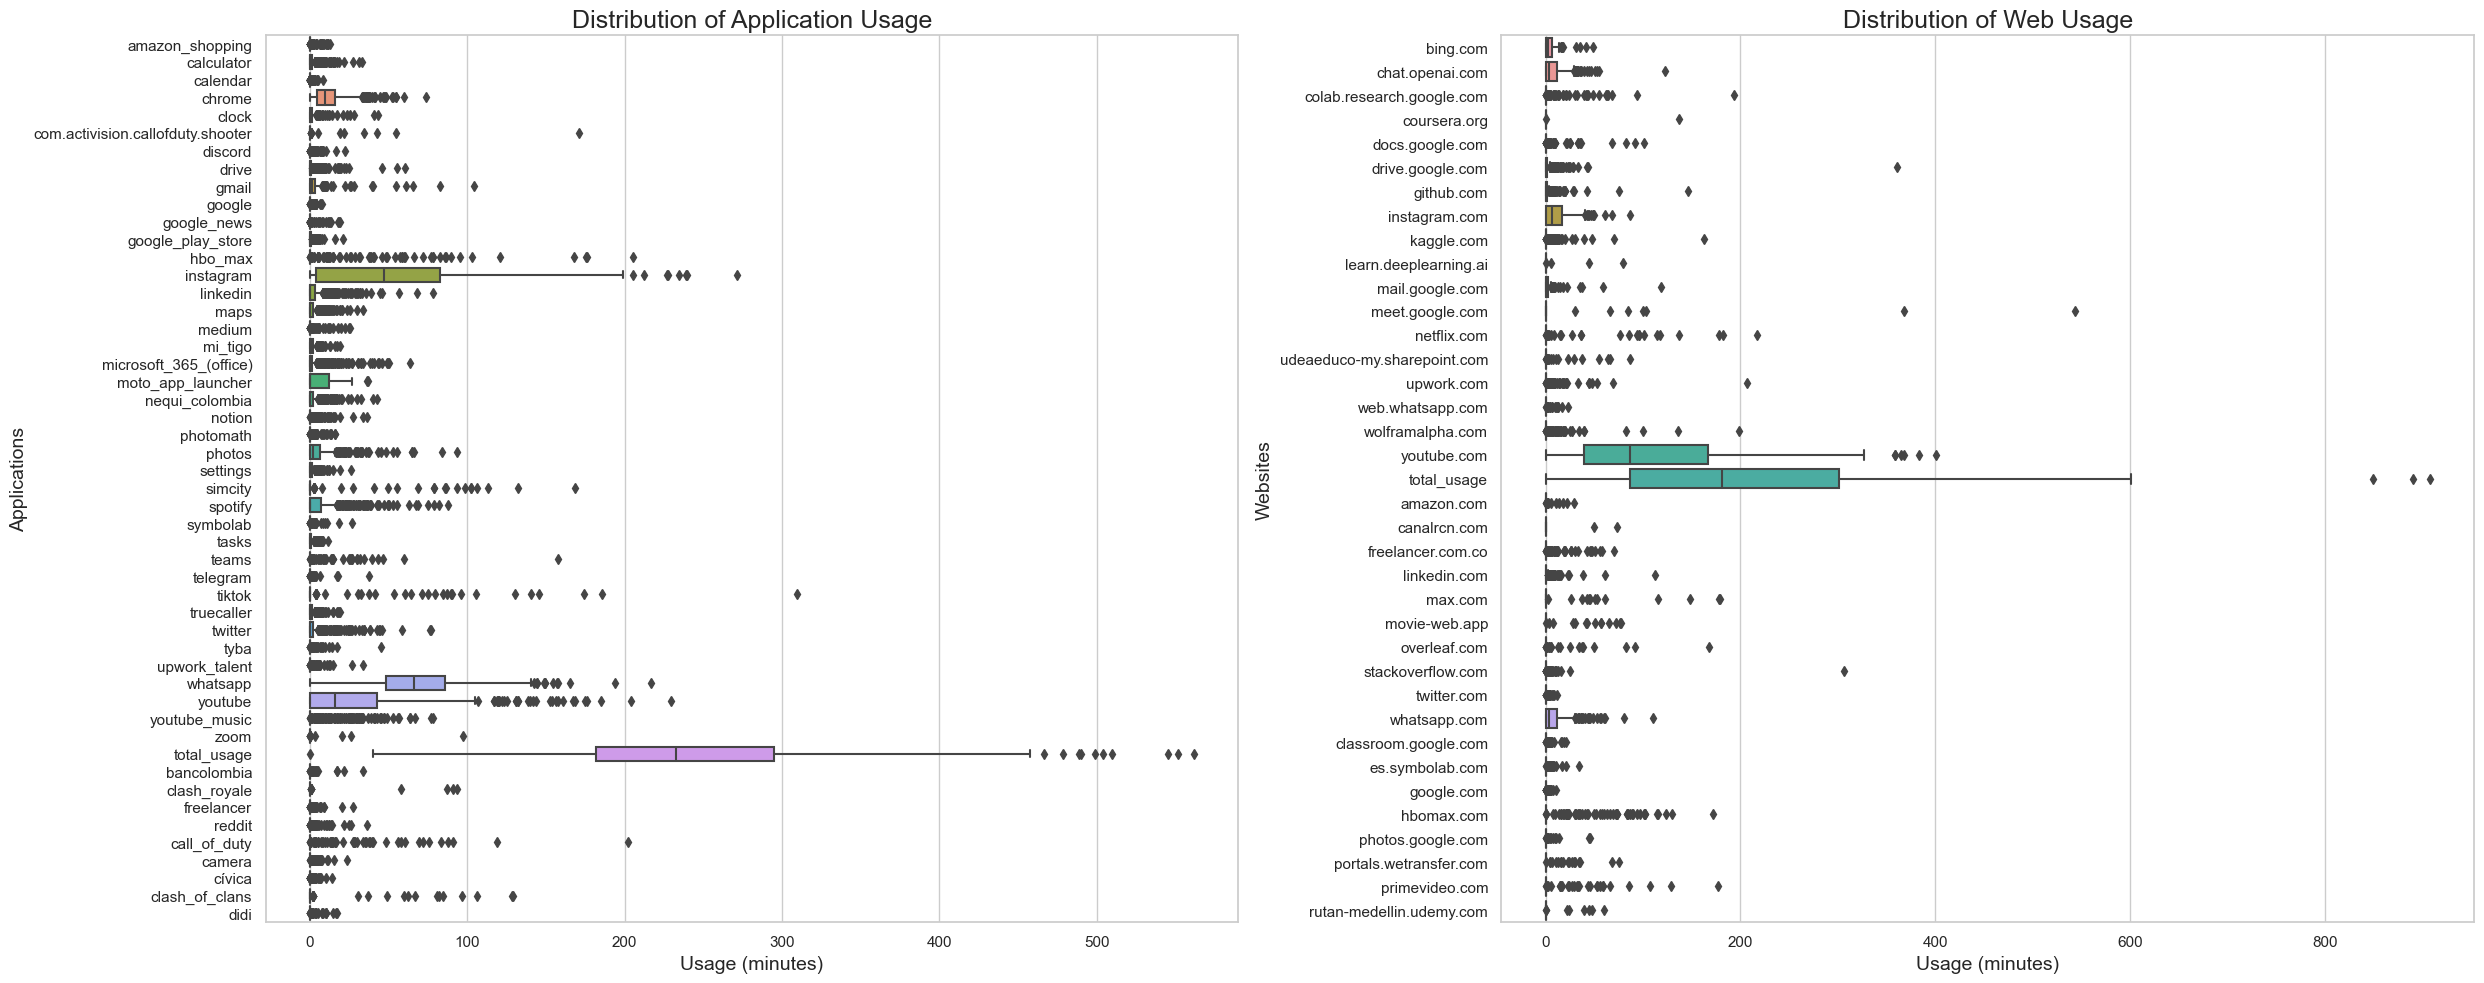

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

# Application usage time boxplot
sns.boxplot(data=app_time_motorola[app_columns], orient='h', ax=axs[0])
axs[0].set_title('Distribution of Application Usage', fontsize=18)
axs[0].set_xlabel('Usage (minutes)', fontsize=14)
axs[0].set_ylabel('Applications', fontsize=14)

# Web usage time boxplot
sns.boxplot(data=web_time_edge[web_columns], orient='h', ax=axs[1])
axs[1].set_title('Distribution of Web Usage', fontsize=18)
axs[1].set_xlabel('Usage (minutes)', fontsize=14)
axs[1].set_ylabel('Websites', fontsize=14)

plt.tight_layout()
plt.show()

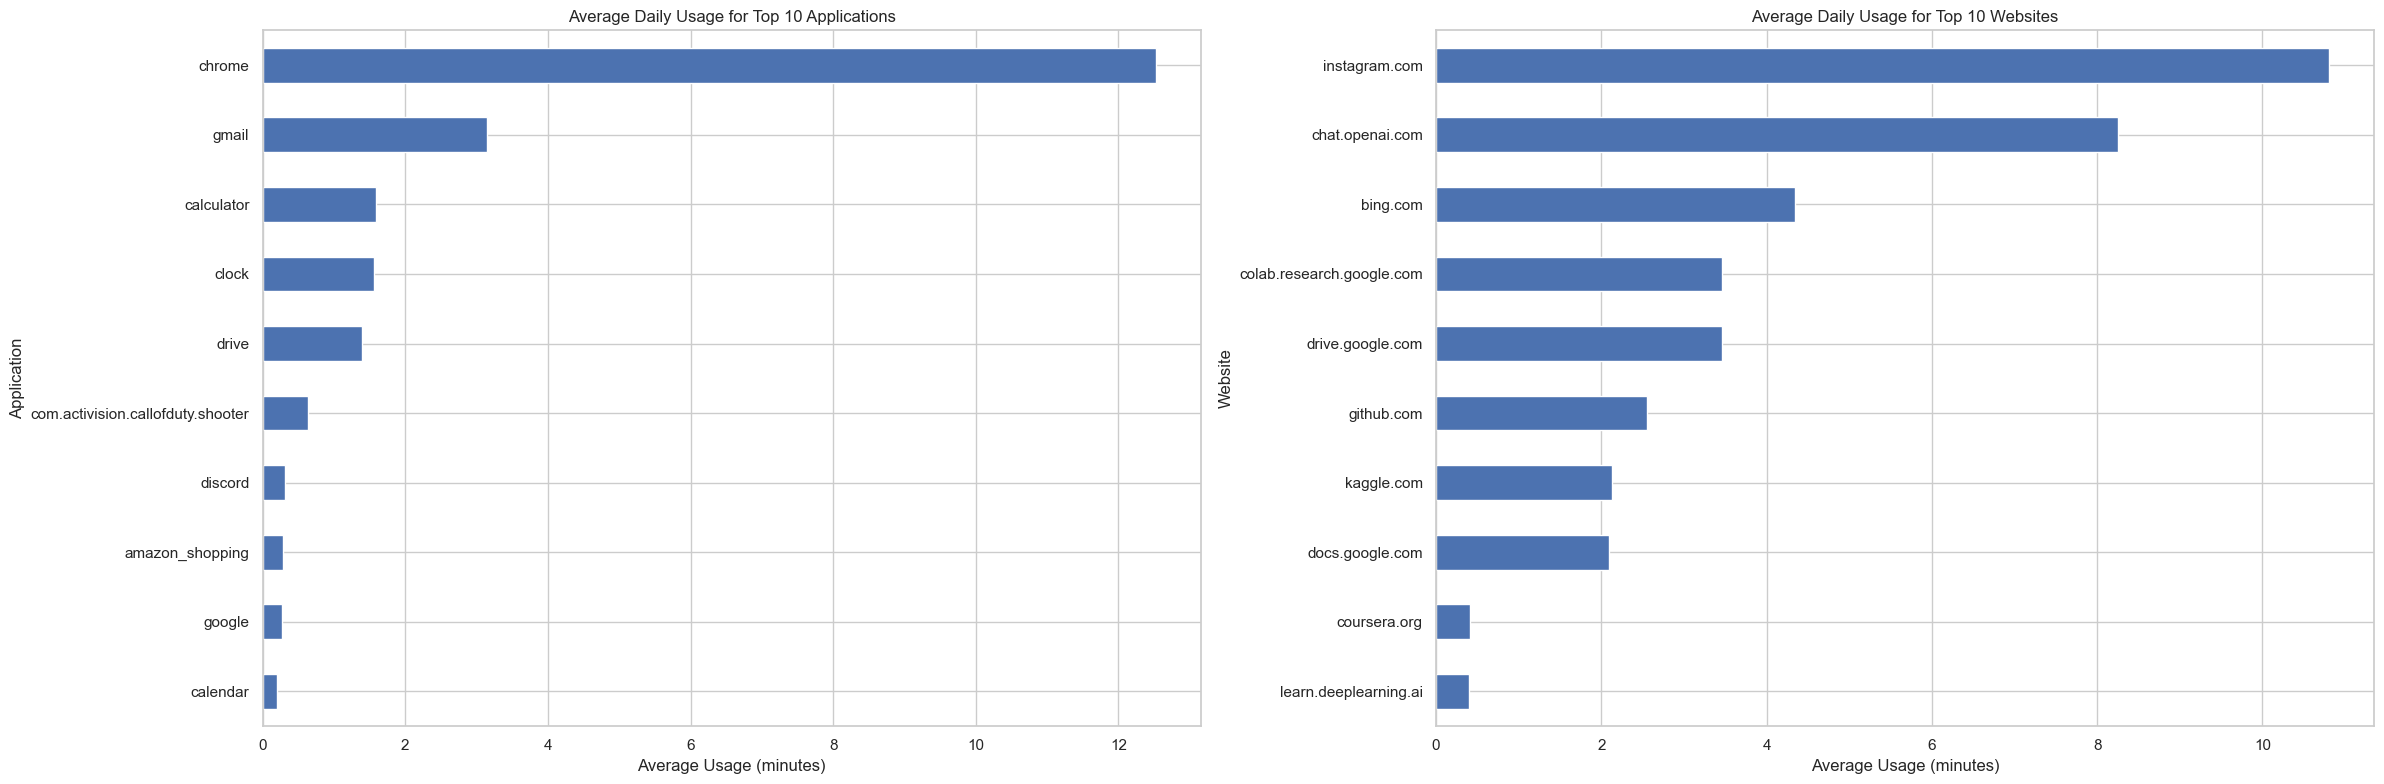

In [137]:
# Calculate average daily usage for each application and website
daily_avg_app_usage = app_time_motorola[app_columns].mean()[:10]
daily_avg_web_usage = web_time_edge[web_columns].mean()[:10]

fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting average daily usage for each application
daily_avg_app_usage.sort_values().plot(kind='barh', ax=axs[0])
axs[0].set_title('Average Daily Usage for Top 10 Applications')
axs[0].set_xlabel('Average Usage (minutes)')
axs[0].set_ylabel('Application')

# Plotting average daily usage for each website
daily_avg_web_usage.sort_values().plot(kind='barh', ax=axs[1])
axs[1].set_title('Average Daily Usage for Top 10 Websites')
axs[1].set_xlabel('Average Usage (minutes)')
axs[1].set_ylabel('Website')

plt.tight_layout()
plt.show()

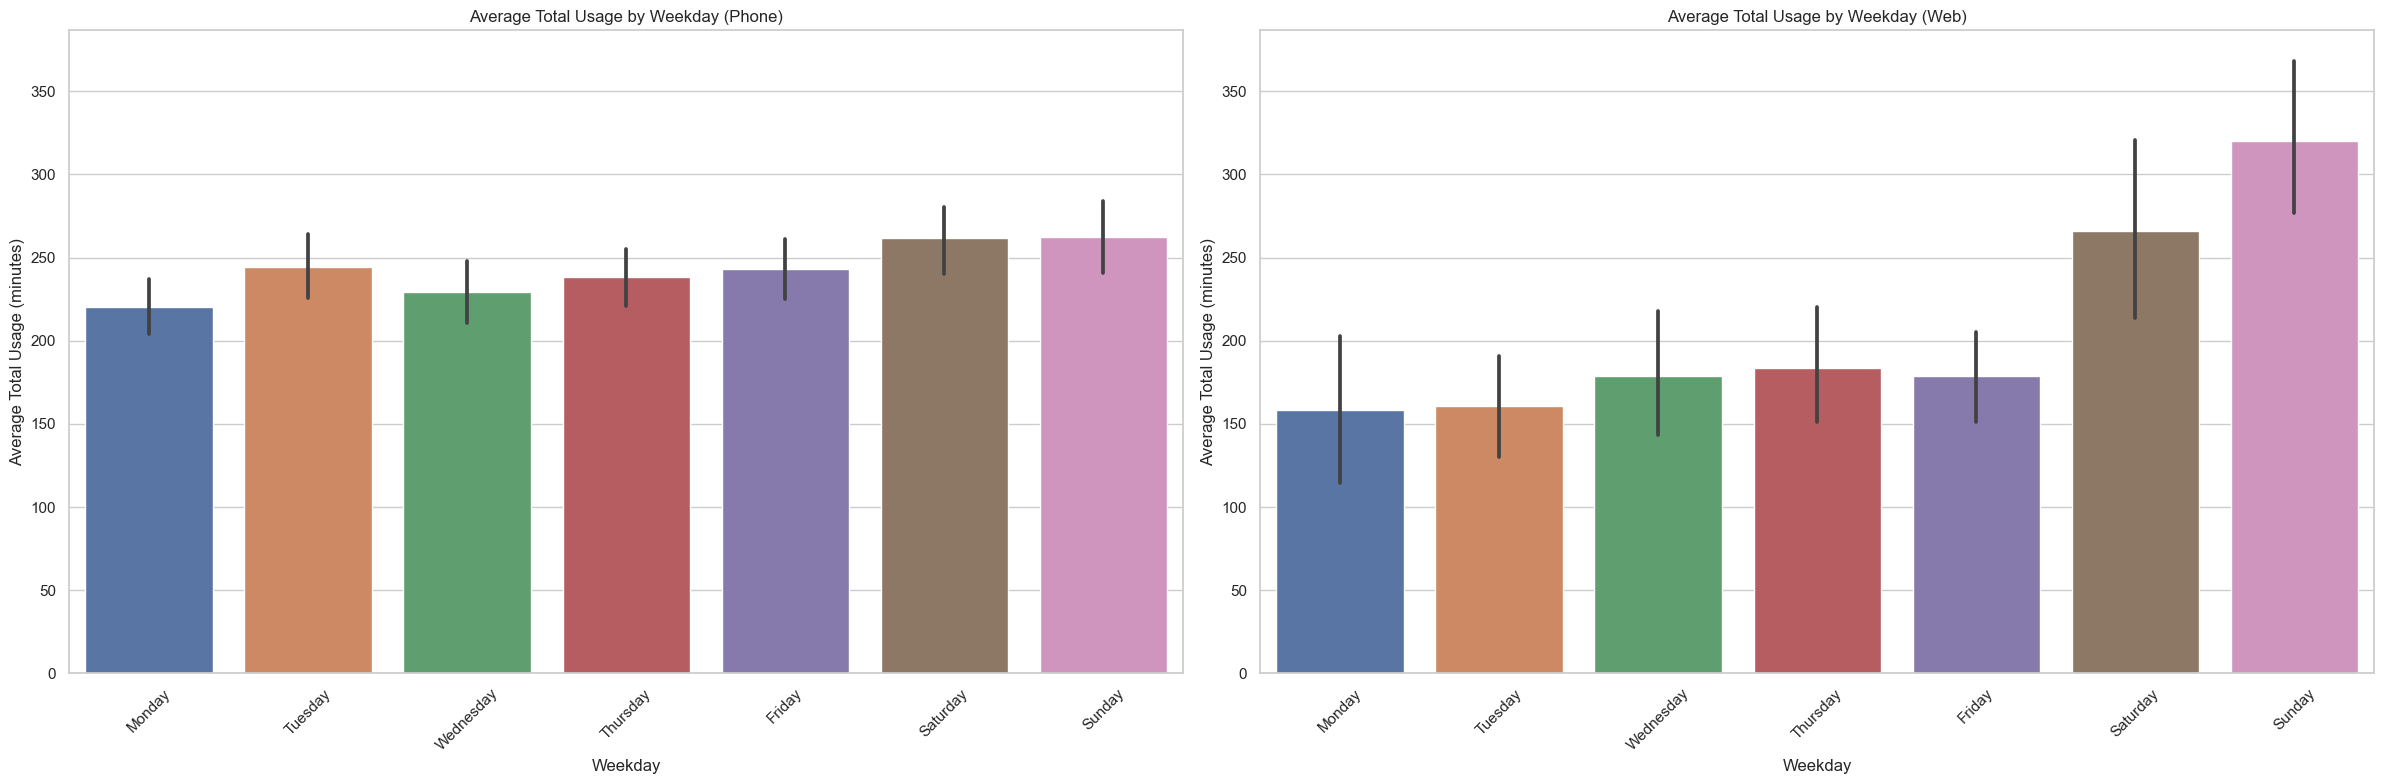

In [138]:
# Extract weekday from the date column
app_time_motorola['weekday'] = pd.to_datetime(app_time_motorola['date']).dt.weekday
web_time_edge['weekday'] = pd.to_datetime(web_time_edge['date']).dt.weekday

# Map weekday numbers to names
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
app_time_motorola['weekday_name'] = app_time_motorola['weekday'].map(weekday_names)
web_time_edge['weekday_name'] = web_time_edge['weekday'].map(weekday_names)

fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting average usage by weekday for app_time_motorola
sns.barplot(x='weekday_name', y='total_usage', data=app_time_motorola, order=weekday_names.values(), ax=axs[0])
axs[0].set_title('Average Total Usage by Weekday (Phone)')
axs[0].set_xlabel('Weekday')
axs[0].set_ylabel('Average Total Usage (minutes)')
axs[0].tick_params(axis='x', rotation=45)

# Plotting average usage by weekday for web_time_edge
sns.barplot(x='weekday_name', y='total_usage', data=web_time_edge, order=weekday_names.values(), ax=axs[1])
axs[1].set_title('Average Total Usage by Weekday (Web)')
axs[1].set_xlabel('Weekday')
axs[1].set_ylabel('Average Total Usage (minutes)')
axs[1].tick_params(axis='x', rotation=45)

# Get the current y-axis limits
ymin0, ymax0 = axs[0].get_ylim()
ymin1, ymax1 = axs[1].get_ylim()

# Set the y-axis limits to the maximum range
axs[0].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))
axs[1].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))

plt.tight_layout()
plt.show()

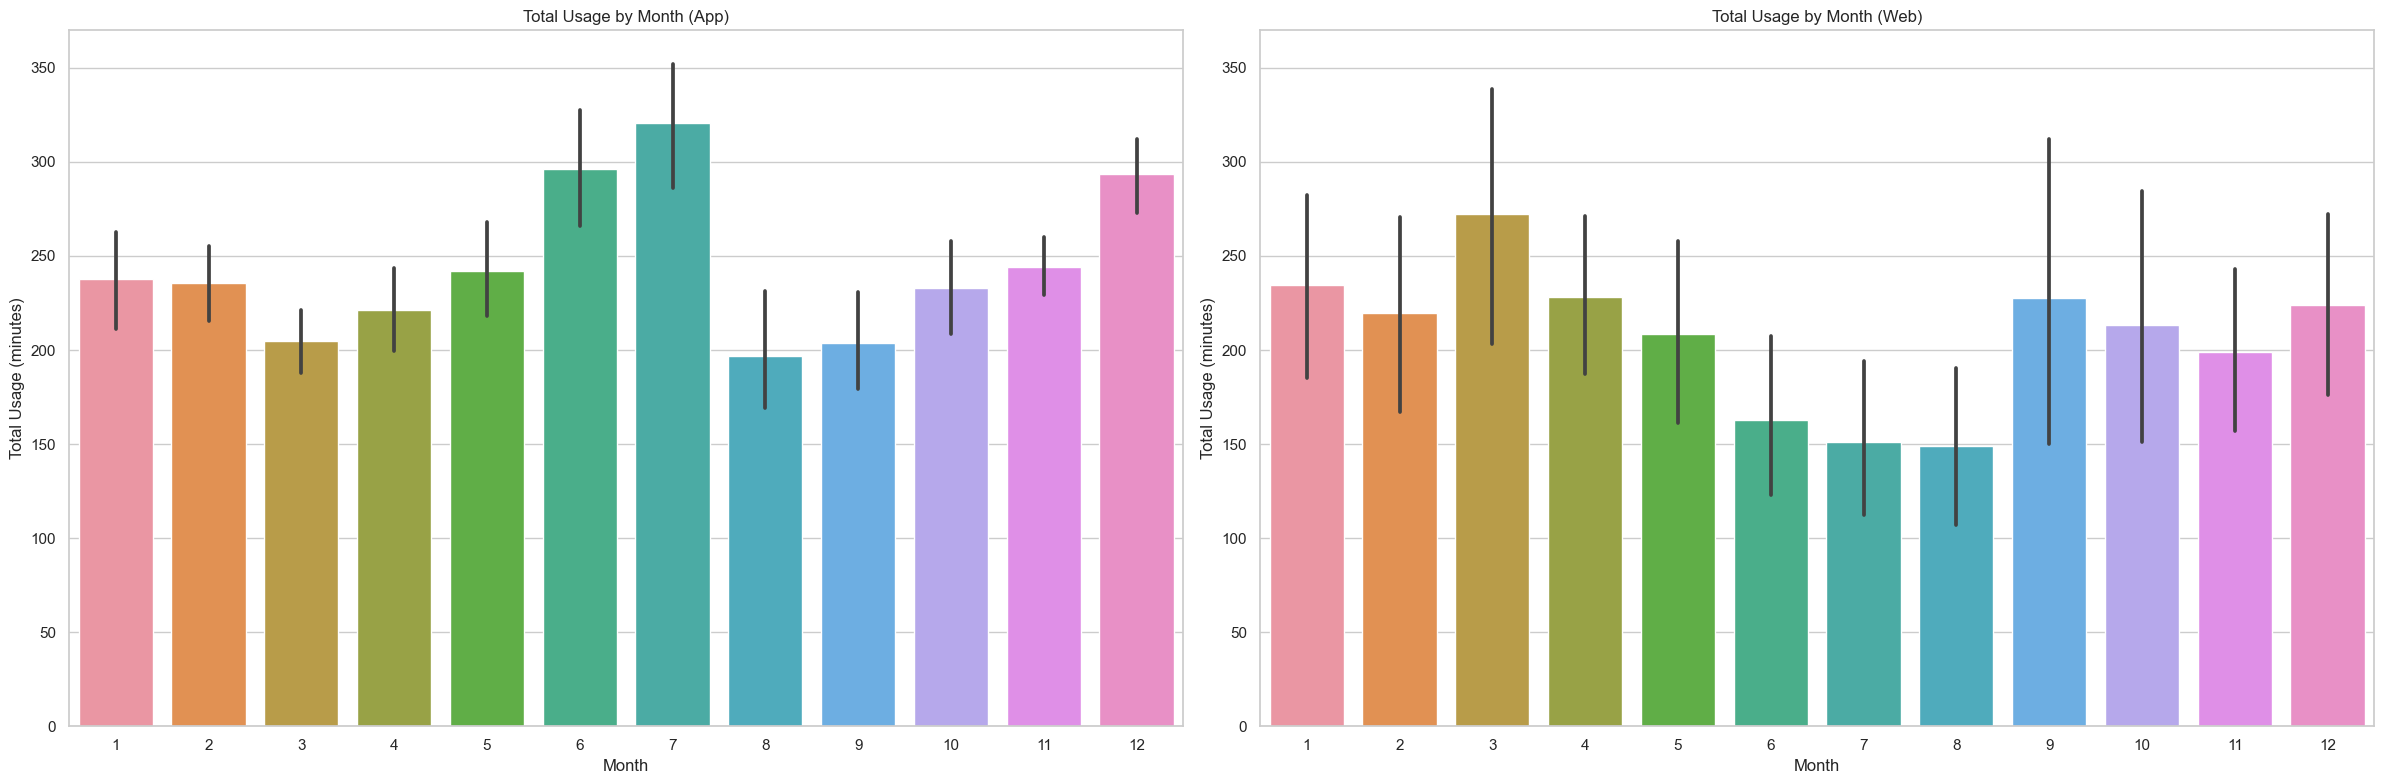

In [139]:
# Extract month from the date column
app_time_motorola['month'] = pd.to_datetime(app_time_motorola['date']).dt.month
web_time_edge['month'] = pd.to_datetime(web_time_edge['date']).dt.month

fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting total usage by month for app_time_motorola
sns.barplot(x='month', y='total_usage', data=app_time_motorola, ax=axs[0])
axs[0].set_title('Total Usage by Month (App)')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Total Usage (minutes)')
axs[0].set_xticks(range(0, 12))

# Plotting total usage by month for web_time_edge
sns.barplot(x='month', y='total_usage', data=web_time_edge, ax=axs[1])
axs[1].set_title('Total Usage by Month (Web)')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Total Usage (minutes)')
axs[1].set_xticks(range(0, 12))

# Get the current y-axis limits
ymin0, ymax0 = axs[0].get_ylim()
ymin1, ymax1 = axs[1].get_ylim()

# Set the y-axis limits to the maximum range
axs[0].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))
axs[1].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))

plt.tight_layout()
plt.show()

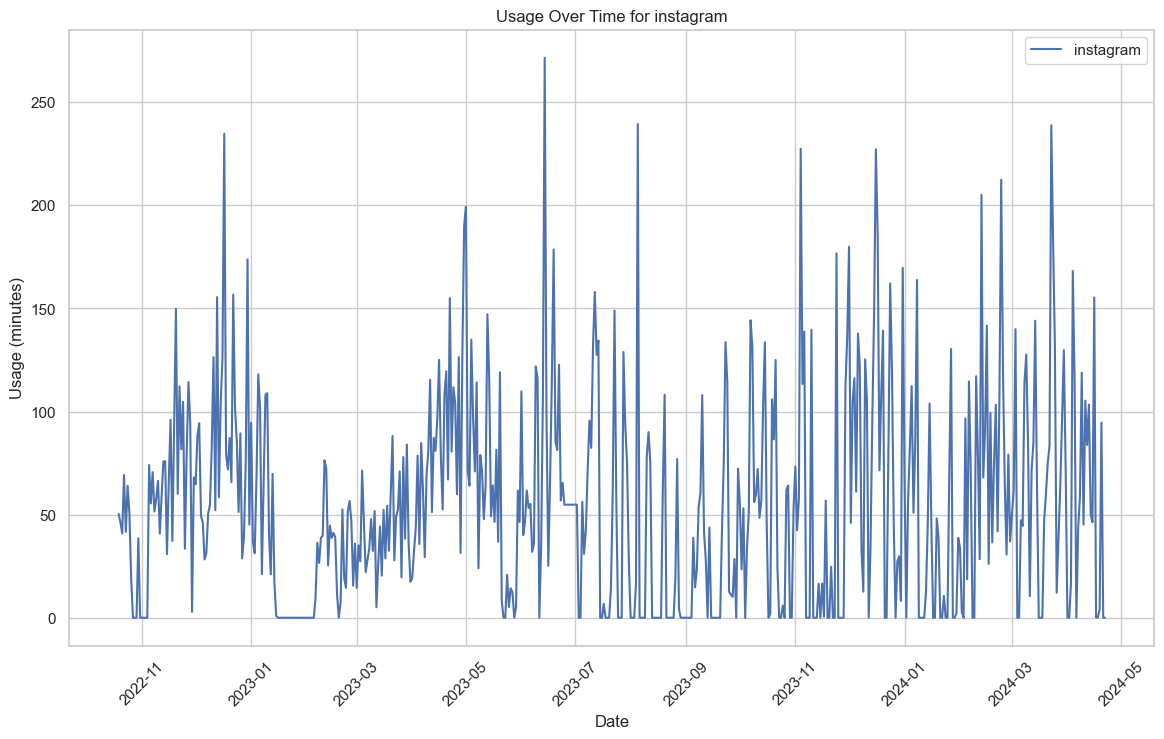

In [140]:
# Define the application to consider
app = 'instagram'

# Plotting usage of the application over time
plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y=app, data=app_time_motorola, label=app)
plt.title(f'Usage Over Time for {app}')
plt.xlabel('Date')
plt.ylabel('Usage (minutes)')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

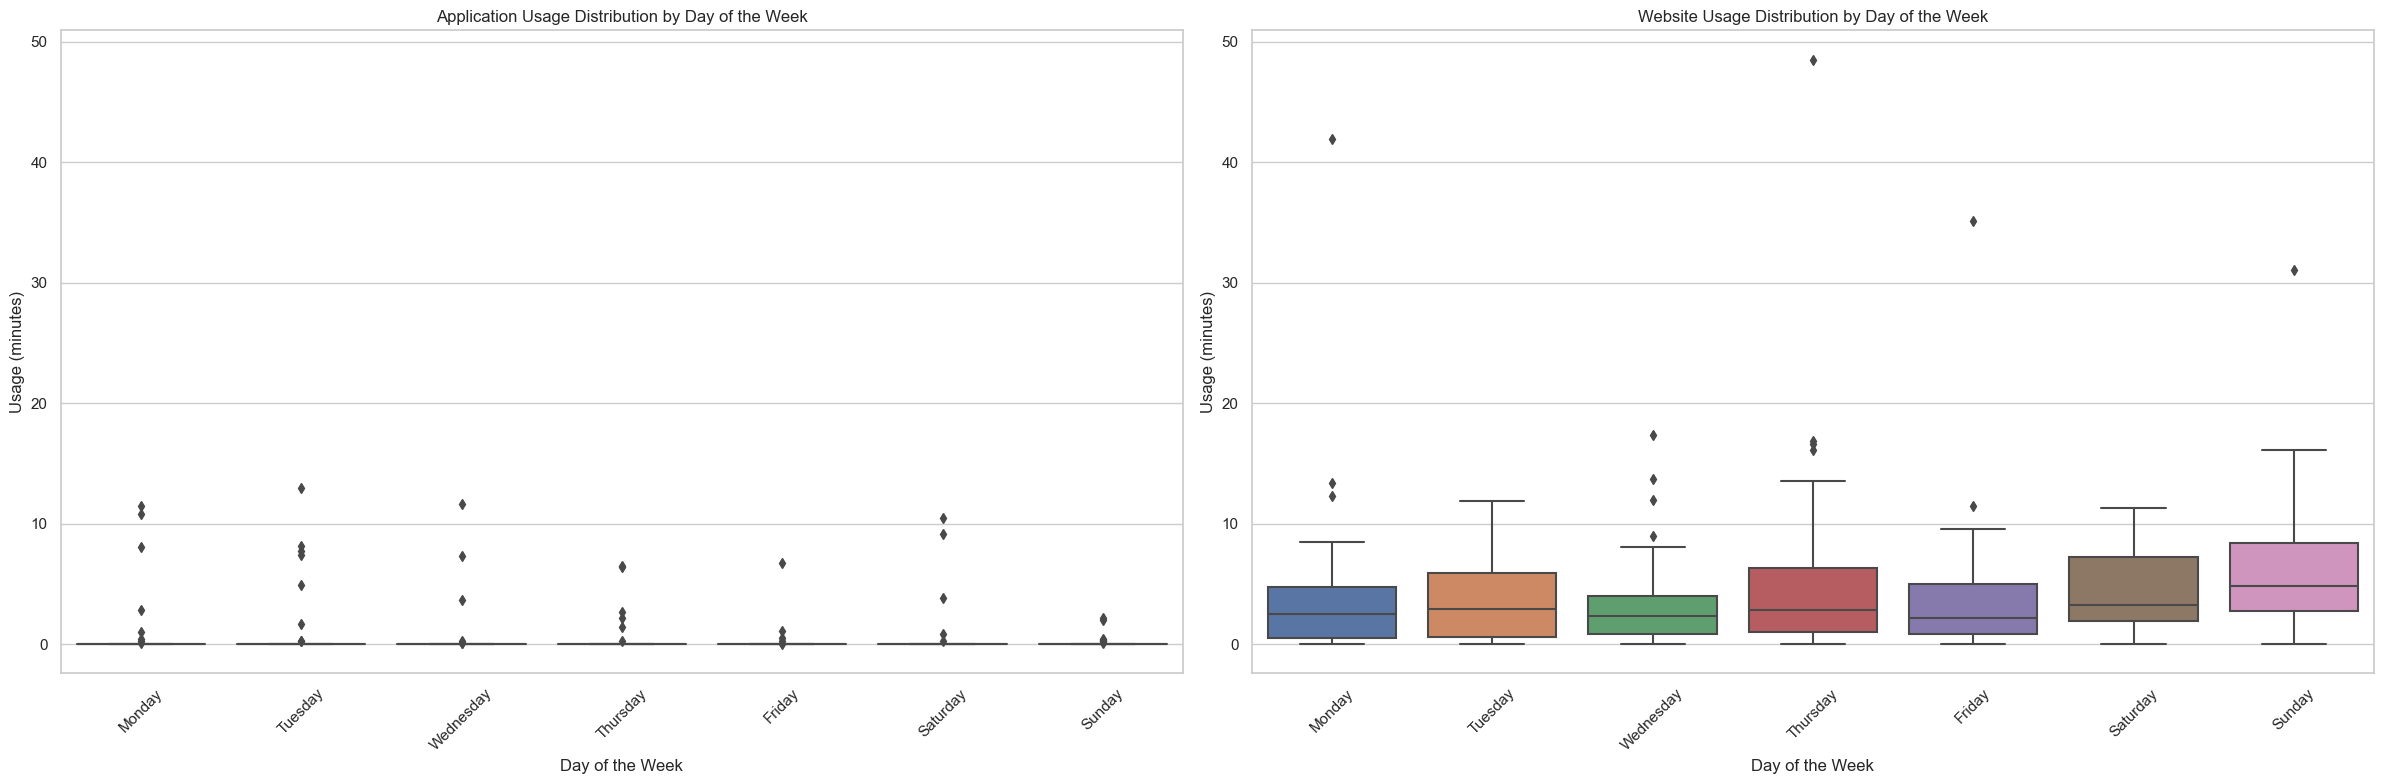

In [141]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# Plotting application usage distribution by day of the week for app_time_motorola
sns.boxplot(data=app_time_motorola, x='weekday_name', y=app_columns[0], order=weekday_names.values(), ax=axs[0])
axs[0].set_title('Application Usage Distribution by Day of the Week')
axs[0].set_xlabel('Day of the Week')
axs[0].set_ylabel('Usage (minutes)')
axs[0].tick_params(axis='x', rotation=45)

# Plotting website usage distribution by day of the week for web_time_edge
sns.boxplot(data=web_time_edge, x='weekday_name', y=web_columns[0], order=weekday_names.values(), ax=axs[1])
axs[1].set_title('Website Usage Distribution by Day of the Week')
axs[1].set_xlabel('Day of the Week')
axs[1].set_ylabel('Usage (minutes)')
axs[1].tick_params(axis='x', rotation=45)

# Get the current y-axis limits
ymin0, ymax0 = axs[0].get_ylim()
ymin1, ymax1 = axs[1].get_ylim()

# Set the y-axis limits to the maximum range
axs[0].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))
axs[1].set_ylim(min(ymin0, ymin1), max(ymax0, ymax1))

plt.tight_layout()
plt.show()

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np

def preprocess(df, target='total_usage'):
    print(f"Original shape: {df.shape}")

    # Remove outliers
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[target] < (Q1 - 1.5 * IQR)) |(df[target] > (Q3 + 1.5 * IQR)))]

    print(f"Shape after outlier removal: {df.shape}")

    # Feature engineering
    df.set_index('date', inplace=True)
    df['day'] = df.index.day
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    # df['weekofyear'] = df.index.weekofyear
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # Normalize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

    # Create train-test split
    X = df_scaled.drop(target, axis=1)
    y = df_scaled[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, df.loc[X_train.index], df.loc[X_test.index]

def forecast(X_train, X_test, y_train, y_test, df_train, df_test):
    
    #Linear regression model
    linear = LinearRegression()
    linear = linear.fit(X_train, y_train)
    y_pred_linear = linear.predict(X_test)
    linear_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_linear))
    
    #XGBoost model
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=2,
                       learning_rate=0.01, )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    y_pred_xgb = reg.predict(X_test)
    xgb_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    
    #Arima model
    model = auto_arima(y_train, 
                   exogenous=X_train, 
                   seasonal=False,
                   trace=True,
                   error_action='ignore', 
                   suppress_warnings=True)

    y_pred_arima = model.predict(n_periods=len(y_test), exogenous=X_test)
    arima_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    
    #Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    rf_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    
    return print(f'RMSE Linear model = {linear_RMSE}\nRMSE XGBoost model = {xgb_RMSE}\nRMSE Arima = {arima_RMSE}\nRMSE Random Forest = {rf_RMSE}') 

In [145]:
web_time_edge.drop(columns=['weekday_name'], inplace=True)

In [146]:
# Apply the functions to your datasets
X_train, X_test, y_train, y_test, df_train, df_test = preprocess(web_time_edge)
forecast(X_train, X_test, y_train, y_test, df_train, df_test)

Original shape: (330, 41)
Shape after outlier removal: (327, 41)
[0]	validation_0-rmse:1.12307	validation_1-rmse:1.05588


[100]	validation_0-rmse:0.64038	validation_1-rmse:0.60071


C:\Users\User\AppData\Local\Temp\ipykernel_16656\149842422.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
C:\Users\User\AppData\Local\Temp\ipykernel_16656\149842422.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.index.year
C:\Users\User\AppData\Local\Temp\ipykernel_16656\149842422.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[200]	validation_0-rmse:0.46737	validation_1-rmse:0.44867
[300]	validation_0-rmse:0.38229	validation_1-rmse:0.39435
[400]	validation_0-rmse:0.32978	validation_1-rmse:0.36751
[500]	validation_0-rmse:0.29514	validation_1-rmse:0.35151
[600]	validation_0-rmse:0.26962	validation_1-rmse:0.34279
[700]	validation_0-rmse:0.25067	validation_1-rmse:0.33696
[800]	validation_0-rmse:0.23534	validation_1-rmse:0.33207
[900]	validation_0-rmse:0.22237	validation_1-rmse:0.32917
[999]	validation_0-rmse:0.21138	validation_1-rmse:0.32472
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=767.726, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=762.309, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=764.192, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=764.166, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=765.089, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=763.740, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]         

d:\Estiven\Datos\virtual-envs\statistics_of_use_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Estiven\Datos\virtual-envs\statistics_of_use_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE Linear model = 0.08095653398996137
RMSE XGBoost model = 0.3247198791728295
RMSE Arima = 0.8313976822053962
RMSE Random Forest = 0.35481245379376686


In [147]:
app_time_motorola.drop(columns=['weekday_name'], inplace=True)

In [148]:
X_train, X_test, y_train, y_test, df_train, df_test = preprocess(app_time_motorola)
forecast(X_train, X_test, y_train, y_test, df_train, df_test)

Original shape: (552, 54)
Shape after outlier removal: (541, 54)
[0]	validation_0-rmse:1.11422	validation_1-rmse:1.10683
[100]	validation_0-rmse:0.78979	validation_1-rmse:0.81963


C:\Users\User\AppData\Local\Temp\ipykernel_16656\149842422.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
C:\Users\User\AppData\Local\Temp\ipykernel_16656\149842422.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.index.year
C:\Users\User\AppData\Local\Temp\ipykernel_16656\149842422.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

[200]	validation_0-rmse:0.64511	validation_1-rmse:0.70738
[300]	validation_0-rmse:0.55425	validation_1-rmse:0.64059
[400]	validation_0-rmse:0.48947	validation_1-rmse:0.59173
[500]	validation_0-rmse:0.44254	validation_1-rmse:0.55790
[600]	validation_0-rmse:0.40544	validation_1-rmse:0.53387
[700]	validation_0-rmse:0.37407	validation_1-rmse:0.51244
[800]	validation_0-rmse:0.34795	validation_1-rmse:0.49460
[900]	validation_0-rmse:0.32493	validation_1-rmse:0.47945
[999]	validation_0-rmse:0.30508	validation_1-rmse:0.46344
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1229.155, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1224.448, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1226.356, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1226.366, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1225.967, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1226.390, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]   

d:\Estiven\Datos\virtual-envs\statistics_of_use_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Estiven\Datos\virtual-envs\statistics_of_use_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE Linear model = 1.8620939968300783e-15
RMSE XGBoost model = 0.46343874921654743
RMSE Arima = 1.0159332771901668
RMSE Random Forest = 0.5448112809709728
